In [1]:
# Import packages
import geopandas as gpd
import numpy as np
import pandas as pd
import libpysal
import networkx as nx
import osmnx as ox
import time
from shapely import geometry
from shapely.geometry import Point, MultiLineString
from shapely.ops import nearest_points

In [2]:
# Import greenspace and population grids
Penn_bound = gpd.read_file('boundaries.shp')
Philly_greenspace = gpd.read_file('Public_greenspace.gpkg')
Philly_popgrid = gpd.read_file('CPoPGrid.gpkg')
Philly_bound = Penn_bound[Penn_bound['municipal1'] == 'PHILADELPHIA']

In [3]:
# Check size of the datasets
print(str('greenspace rows: ') + str(Philly_greenspace.shape[0])  + str(', ') +
str('population grid rows: ') + str(Philly_popgrid.shape[0]))

greenspace rows: 1360, population grid rows: 21442


<AxesSubplot:>

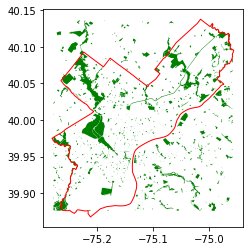

In [4]:
# Check the datasets
ax = Philly_greenspace.plot(facecolor='green')
Philly_bound.plot(ax=ax, facecolor='None', edgecolor='red')

In [5]:
# Check if crs equals
(Philly_bound.crs == Philly_greenspace.crs) & (Philly_bound.crs == Philly_popgrid.crs)

False

In [6]:
# Set crs to WGS84
Philly_bound = Philly_bound.to_crs(4326)
Philly_greenspace = Philly_greenspace.to_crs(4326)
Philly_popgrid = Philly_popgrid.to_crs(4326)

In [7]:
# Set buffer. Crs 3043 measures the world in metres, you can set a buffer in metres and set the data again in WGS84
green_buffer = gpd.GeoDataFrame(geometry = Philly_greenspace.to_crs(3043).buffer(25).to_crs(4326))
green_buffer

,geometry
0,"POLYGON ((-75.09191 39.91345, -75.09192 39.913..."
1,"POLYGON ((-75.02347 39.89392, -75.02348 39.893..."
2,"POLYGON ((-75.02108 39.90248, -75.02122 39.902..."
3,"POLYGON ((-75.08855 39.93442, -75.08855 39.934..."
4,"POLYGON ((-75.08892 39.93441, -75.08893 39.934..."
...,...
1355,"POLYGON ((-75.25915 40.05679, -75.25889 40.057..."
1356,"POLYGON ((-75.25923 40.05563, -75.25924 40.055..."
1357,"POLYGON ((-75.25911 40.05575, -75.25912 40.055..."
1358,"POLYGON ((-75.24564 40.09203, -75.24564 40.092..."


In [8]:
# This function group components in itself that overlap (with the buffer set of 25 metres)
# https://stackoverflow.com/questions/68036051/geopandas-self-intersection-grouping
W = libpysal.weights.fuzzy_contiguity(green_buffer)
Philly_greenspace['components'] = W.component_labels
Philly_parks = Philly_greenspace.dissolve('components')

C:\Users\bartb\miniconda3\envs\ssml\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 747 disconnected components.
 There are 585 islands with ids: 11, 15, 26, 28, 45, 52, 53, 61, 65, 68, 71, 89, 90, 91, 95, 96, 97, 98, 103, 104, 105, 106, 107, 108, 110, 117, 118, 127, 133, 134, 138, 139, 148, 149, 153, 154, 155, 156, 157, 159, 163, 168, 171, 173, 174, 177, 181, 182, 185, 186, 189, 190, 191, 192, 193, 195, 197, 198, 199, 200, 201, 202, 203, 217, 221, 228, 232, 235, 239, 240, 241, 242, 245, 249, 255, 256, 261, 262, 264, 266, 267, 272, 273, 275, 276, 280, 285, 286, 288, 290, 292, 301, 303, 304, 307, 310, 313, 315, 316, 318, 320, 321, 322, 326, 327, 328, 329, 330, 331, 332, 335, 336, 337, 341, 342, 343, 344, 348, 349, 351, 355, 356, 357, 358, 359, 362, 363, 370, 371, 385, 437, 445, 449, 450, 451, 460, 461, 462, 463, 466, 467, 473, 483, 484, 485, 497, 498, 499, 503, 504, 547, 562, 564, 566, 569, 578, 579, 581, 582, 583, 5

In [9]:
# Exclude parks below 0.04 ha.
Philly_parks = Philly_parks[Philly_parks.to_crs(3043).area > 400]

<AxesSubplot:>

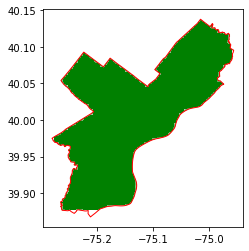

In [10]:
# Check if population grids are within Philadelphia
ax = Philly_popgrid.overlay(Philly_bound).plot(facecolor='green')
Philly_bound.plot(ax=ax, facecolor='None', edgecolor='red')

In [11]:
# Make sure only complete overlays progress and take their centroids
popgrid = Philly_popgrid.overlay(Philly_bound)
popgrid['centroid'] = popgrid.centroid
popgrid['centroid_m'] = popgrid['centroid'].to_crs(3043)

C:\Users\bartb\AppData\Local\Temp\ipykernel_27856\2997288678.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  popgrid['centroid'] = popgrid.centroid


In [12]:
# Take a buffer for the parks to ensure equal measurements for edge population grids
boundaries_buffer = gpd.GeoDataFrame(geometry = Philly_bound.to_crs(3043).buffer(1000).to_crs(4326))
parks_within_range = Philly_parks.overlay(boundaries_buffer)
parks_within_range['centroid'] = parks_within_range.centroid
parks_within_range['centroid_m'] = parks_within_range['centroid'].to_crs(3043)

C:\Users\bartb\AppData\Local\Temp\ipykernel_27856\1773636649.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parks_within_range['centroid'] = parks_within_range.centroid


<AxesSubplot:>

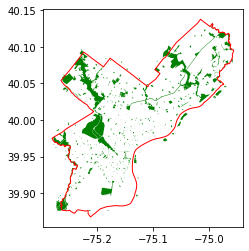

In [13]:
# Check the operation within the plot
ax = parks_within_range.plot(facecolor='green')
mat = np.repeat(np.nan,len(popgrid)*len(parks_within_range)).reshape(len(popgrid), len(parks_within_range))
Philly_bound.plot(ax=ax, facecolor='None', edgecolor='red')

In [14]:
# Check the euclidean distances between the centroids
mat = np.repeat(np.nan,len(popgrid)*len(parks_within_range)).reshape(len(popgrid),len(parks_within_range))
for i in range(len(popgrid)):
    if i % 250 == 0: print(round(i/len(popgrid)*100,2),'% done')
    for j in range(len(parks_within_range)):
        mat[i,j] = popgrid['centroid_m'][i].distance(parks_within_range['centroid_m'][j])
print('100 % done')

0.0 % done
2.41 % done
4.82 % done
7.23 % done
9.64 % done
12.05 % done
14.46 % done
16.87 % done
19.28 % done
21.68 % done
24.09 % done
26.5 % done
28.91 % done
31.32 % done
33.73 % done
36.14 % done
38.55 % done
40.96 % done
43.37 % done
45.78 % done
48.19 % done
50.6 % done
53.01 % done
55.42 % done
57.83 % done
60.24 % done
62.64 % done
65.05 % done
67.46 % done
69.87 % done
72.28 % done
74.69 % done
77.1 % done
79.51 % done
81.92 % done
84.33 % done
86.74 % done
89.15 % done
91.56 % done
93.97 % done
96.38 % done
98.79 % done
100 % done


In [15]:
# Check all parks within a kilometre euclidean distance
mat2 = []
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        if mat[i,j] <= 1000:
            mat2.append([i,j,mat[i,j]])
mat2 = pd.DataFrame(mat2)
mat2.columns = ['Grid_no','Park_no','Eucl_dist']
mat2 = pd.merge(mat2, parks_within_range['centroid'], left_on = 'Park_no', right_index = True)
mat2 = pd.merge(mat2, popgrid['centroid'], left_on = 'Grid_no', right_index = True)
mat2.rename(columns = {'centroid_x':'park_centroid', 'centroid_y':'popgrid_centroid'}, inplace = True)
mat2

,Grid_no,Park_no,Eucl_dist,park_centroid,popgrid_centroid
0,20,62,564.704411,POINT (-74.99398 40.12845),POINT (-74.99390 40.13183)
1,32,62,365.731436,POINT (-74.99398 40.12845),POINT (-74.99480 40.13055)
2,33,62,399.683354,POINT (-74.99398 40.12845),POINT (-74.99362 40.13083)
3,46,62,807.153968,POINT (-74.99398 40.12845),POINT (-75.00027 40.12876)
4,47,62,370.533414,POINT (-74.99398 40.12845),POINT (-74.99686 40.12863)
...,...,...,...,...,...
16207,10368,177,293.766906,POINT (-75.21314 39.87637),POINT (-75.21102 39.87702)
16208,10369,177,573.713643,POINT (-75.21314 39.87637),POINT (-75.20878 39.87702)
16209,10370,177,860.586076,POINT (-75.21314 39.87637),POINT (-75.20653 39.87702)
16178,10309,24,985.208017,POINT (-75.18003 39.87634),POINT (-75.18439 39.88115)


In [16]:
# Import. The buffer is pre-set to fit equal oppertunities for population grids (1 km) 
road_nodes = gpd.read_file('nodes.shp')
for i in range(len(road_nodes)):
    road_nodes['geometry'][i] = Point(road_nodes['lon'][i], road_nodes['lat'][i])
road_nodes

,osmid,y,x,street_cou,lon,lat,highway,ref,geometry
0,103323284,4.428318e+06,496884.233211,4,-75.036504,40.005045,None,None,POINT (-75.037 40.005)
1,772373286,4.428457e+06,496773.290262,2,-75.037805,40.006302,None,None,POINT (-75.038 40.006)
2,103340244,4.428413e+06,496975.420005,5,-75.035436,40.005903,traffic_signals,None,POINT (-75.035 40.006)
3,103339825,4.428773e+06,497258.271105,3,-75.032124,40.009152,None,None,POINT (-75.032 40.009)
4,103339864,4.429054e+06,497223.892925,1,-75.032528,40.011683,None,None,POINT (-75.033 40.012)
...,...,...,...,...,...,...,...,...,...
28001,9068845681,4.424701e+06,484939.244304,4,-75.176367,39.972330,None,None,POINT (-75.176 39.972)
28002,9068845682,4.424701e+06,484935.554944,4,-75.176411,39.972329,None,None,POINT (-75.176 39.972)
28003,9244049904,4.423347e+06,488292.404747,3,-75.137076,39.960185,None,None,POINT (-75.137 39.960)
28004,9518379104,4.422520e+06,484692.573049,1,-75.179205,39.952676,None,None,POINT (-75.179 39.953)


In [97]:
# Impor the road edges with the same buffer.
road_edges = gpd.read_file('edges.shp')
road_edges.to_crs(4326)
road_edges

# Get both ways
road_edges2 = road_edges[['osmid','from','to','name','length','geometry']]
road_edges2.columns = ['osmid','to','from','name','length','geometry']
road_edges2 = road_edges2[['osmid','from','to','name','length','geometry']]
road_connections = pd.concat([road_edges, road_edges2]).to_crs(4326)


In [18]:
# Get the graph object
graph = graph = ox.graph_from_place('Philadelphia, United States', network_type="drive", buffer_dist = 2000)
graph = ox.speed.add_edge_speeds(graph)
graph = ox.speed.add_edge_travel_times(graph)

C:\Users\bartb\miniconda3\envs\ssml\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [20]:
# Get the nearest entry node for each park and population grid centroid
start_time = time.time()
mat2['park_entry_no'] = ''
mat2['popgrid_entry_no'] = ''
mat2['park_entry_point'] = ''
mat2['popgrid_entry_point'] = ''
mat2['park_entry_osm'] = ''
mat2['popgrid_entry_osm'] = ''
for i in range(len(mat2)):
    mat2['park_entry_no'][i] = int(road_nodes['geometry'].sindex.nearest(Point(mat2['park_centroid'][i]))[1])
    mat2['popgrid_entry_no'][i] = int(road_nodes['geometry'].sindex.nearest(Point(mat2['popgrid_centroid'][i]))[1])
    mat2['park_entry_point'][i] = road_nodes['geometry'][mat2['park_entry_no'][i]]
    mat2['popgrid_entry_point'][i] = road_nodes['geometry'][mat2['popgrid_entry_no'][i]]
    mat2['park_entry_osm'][i] = road_nodes['osmid'][mat2['park_entry_no'][i]]
    mat2['popgrid_entry_osm'][i] = road_nodes['osmid'][mat2['popgrid_entry_no'][i]]
    if i % 250 == 0: print(round(i/len(mat2)*100,2),'%',round((time.time() - start_time) / 60,2),' mns')
print('100% done')

C:\Users\bartb\AppData\Local\Temp\ipykernel_27856\1939755523.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat2['park_entry_no'][i] = int(road_nodes['geometry'].sindex.nearest(Point(mat2['park_centroid'][i]))[1])
C:\Users\bartb\AppData\Local\Temp\ipykernel_27856\1939755523.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat2['popgrid_entry_no'][i] = int(road_nodes['geometry'].sindex.nearest(Point(mat2['popgrid_centroid'][i]))[1])
C:\Users\bartb\AppData\Local\Temp\ipykernel_27856\1939755523.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

0.0 % 0.0  mns
1.54 % 0.24  mns
3.08 % 0.48  mns
4.63 % 0.72  mns
6.17 % 0.97  mns
7.71 % 1.2  mns
9.25 % 1.43  mns
10.8 % 1.66  mns
12.34 % 1.89  mns
13.88 % 2.13  mns
15.42 % 2.37  mns
16.96 % 2.6  mns
18.51 % 2.83  mns
20.05 % 3.07  mns
21.59 % 3.32  mns
23.13 % 3.55  mns
24.68 % 3.77  mns
26.22 % 3.99  mns
27.76 % 4.22  mns
29.3 % 4.45  mns
30.85 % 4.68  mns
32.39 % 4.9  mns
33.93 % 5.12  mns
35.47 % 5.35  mns
37.01 % 5.59  mns
38.56 % 5.82  mns
40.1 % 6.05  mns
41.64 % 6.27  mns
43.18 % 6.5  mns
44.73 % 6.74  mns
46.27 % 6.97  mns
47.81 % 7.19  mns
49.35 % 7.43  mns
50.89 % 7.66  mns
52.44 % 7.89  mns
53.98 % 8.12  mns
55.52 % 8.34  mns
57.06 % 8.57  mns
58.61 % 8.79  mns
60.15 % 9.03  mns
61.69 % 9.25  mns
63.23 % 9.48  mns
64.77 % 9.7  mns
66.32 % 9.93  mns
67.86 % 10.15  mns
69.4 % 10.38  mns
70.94 % 10.6  mns
72.49 % 10.83  mns
74.03 % 11.05  mns
75.57 % 11.28  mns
77.11 % 11.51  mns
78.66 % 11.74  mns
80.2 % 11.97  mns
81.74 % 12.21  mns
83.28 % 12.44  mns
84.82 % 12.67  mns


In [21]:
# Calculate the distance from park and population grid centroids to the nearest road node.
parkgrid = gpd.GeoDataFrame(mat2, geometry = 'park_centroid', crs = 4326).to_crs(3043)
parkgrid['popgrid_centroid'] = gpd.GeoSeries(parkgrid['popgrid_centroid'], crs = 4326).to_crs(3043)
parkgrid['park_entry_point'] = gpd.GeoSeries(parkgrid['park_entry_point'], crs = 4326).to_crs(3043)
parkgrid['popgrid_entry_point'] = gpd.GeoSeries(parkgrid['popgrid_entry_point'], crs = 4326).to_crs(3043)

# Add those 
mat2['popgriddist_road'] = parkgrid['popgrid_centroid'].distance(parkgrid['popgrid_entry_point'])
mat2['parkdist_road'] = parkgrid['park_centroid'].distance(parkgrid['park_entry_point'])
mat2

,Grid_no,Park_no,Eucl_dist,park_centroid,popgrid_centroid,park_entry_no,popgrid_entry_no,park_entry_point,popgrid_entry_point,park_entry_osm,popgrid_entry_osm,popgriddist_road,parkdist_road
0,20,62,564.704411,POINT (-74.99398 40.12845),POINT (-74.99390 40.13183),19543,24990,POINT (-74.996392 40.127195),POINT (-74.994914 40.132236),110158486,111181724,146.772365,373.040504
1,32,62,365.731436,POINT (-74.99398 40.12845),POINT (-74.99480 40.13055),19543,24989,POINT (-74.996392 40.127195),POINT (-74.995501 40.131224),110158486,111181665,144.111916,373.040504
2,33,62,399.683354,POINT (-74.99398 40.12845),POINT (-74.99362 40.13083),19543,24990,POINT (-74.996392 40.127195),POINT (-74.994914 40.132236),110158486,111181724,287.322762,373.040504
3,46,62,807.153968,POINT (-74.99398 40.12845),POINT (-75.00027 40.12876),19543,24917,POINT (-74.996392 40.127195),POINT (-74.999744 40.128911),110158486,111070974,71.550082,373.040504
4,47,62,370.533414,POINT (-74.99398 40.12845),POINT (-74.99686 40.12863),19543,24918,POINT (-74.996392 40.127195),POINT (-74.997201 40.129508),110158486,111181653,152.869656,373.040504
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16207,10368,177,293.766906,POINT (-75.21314 39.87637),POINT (-75.21102 39.87702),24674,24674,POINT (-75.2125948 39.8769882),POINT (-75.2125948 39.8769882),6647160489,6647160489,203.162576,124.455409
16208,10369,177,573.713643,POINT (-75.21314 39.87637),POINT (-75.20878 39.87702),24674,24674,POINT (-75.2125948 39.8769882),POINT (-75.2125948 39.8769882),6647160489,6647160489,493.475529,124.455409
16209,10370,177,860.586076,POINT (-75.21314 39.87637),POINT (-75.20653 39.87702),24674,24674,POINT (-75.2125948 39.8769882),POINT (-75.2125948 39.8769882),6647160489,6647160489,783.818121,124.455409
16178,10309,24,985.208017,POINT (-75.18003 39.87634),POINT (-75.18439 39.88115),12284,12286,POINT (-75.1801916 39.8871577),POINT (-75.183495 39.88796),8047268627,110451405,1147.807428,1815.721811


In [22]:
# Setting to geodataframe properly
mat2 = gpd.GeoDataFrame(mat2, crs = 4236, geometry = 'park_centroid')
mat2['popgrid_centroid'] = gpd.GeoSeries(mat2['popgrid_centroid'], crs = 4326)
mat2['popgrid_entry_point'] = gpd.GeoSeries(mat2['popgrid_entry_point'], crs = 4326)
mat2['park_entry_point'] = gpd.GeoSeries(mat2['park_entry_point'], crs = 4326)

In [98]:
# Preventing an Python advice at each iteration
import warnings
warnings.filterwarnings("ignore")

start_time = time.time()
route_cost = pd.DataFrame()
for i in range(len(mat2)):
    # First try from population grid to park Dijkstra algorithm
    try:
        shortest = pd.DataFrame(nx.shortest_path(graph, mat2['popgrid_entry_osm'].iloc[i], mat2['park_entry_osm'].iloc[i], 
                                                 'travel_time', method = 'dijkstra'))
        shortest.columns = ['shortest_from']
        shortest['shortest_to'] = shortest.iloc[1:len(shortest),0].reset_index().iloc[:,1]
        shortest.iloc[0:len(shortest)-1,1] = shortest.iloc[0:len(shortest)-1,1].astype(int)
        path_geometry = pd.merge(shortest, road_connections[['osmid','from','to','length','geometry']], 
                                 left_on = ['shortest_to', 'shortest_from'], right_on = ['from', 'to'], how = 'left')
        path_geometry = gpd.GeoDataFrame(path_geometry, geometry = path_geometry['geometry'], crs = 4326)
        route_cost = pd.concat([route_cost,
                            pd.DataFrame([round(path_geometry['length'].sum(),6),
                                          mat2['popgrid_entry_osm'][i],
                                          mat2['park_entry_osm'][i],
                                          mat2['Grid_no'][i],
                                          mat2['Park_no'][i],
                                          str(mat2['Grid_no'][i]) + '-' + str(mat2['Park_no'][i]),
                                          mat2['parkdist_road'][i],
                                          mat2['popgriddist_road'][i],
                                          'popgrid > park',
                                          path_geometry['geometry'].unary_union]).
                                transpose()])
        
    # At ~ 30 routes (1km distance to parks) this doesn't work, but the reverse route (park to popgrid) works.
    except:
        shortest = pd.DataFrame(nx.shortest_path(graph, mat2['park_entry_osm'].iloc[i], mat2['popgrid_entry_osm'].iloc[i],
                                                 'travel_time', method = 'dijkstra'))
        shortest.columns = ['shortest_from']
        shortest['shortest_to'] = shortest.iloc[1:len(shortest),0].reset_index().iloc[:,1]
        shortest.iloc[0:len(shortest)-1,1] = shortest.iloc[0:len(shortest)-1,1].astype(int)
        path_geometry = pd.merge(shortest, road_connections[['osmid','from','to','length','geometry']], 
                                 left_on = ['shortest_to', 'shortest_from'], right_on = ['from', 'to'], how = 'left')
        path_geometry = gpd.GeoDataFrame(path_geometry, geometry = path_geometry['geometry'], crs = 4326)
        route_cost = pd.concat([route_cost,
                            pd.DataFrame([round(path_geometry['length'].sum(),6),
                                          mat2['popgrid_entry_osm'][i],
                                          mat2['park_entry_osm'][i],
                                          mat2['Grid_no'][i],
                                          mat2['Park_no'][i],
                                          str(mat2['Grid_no'][i]) + '-' + str(mat2['Park_no'][i]),
                                          mat2['parkdist_road'][i],
                                          mat2['popgriddist_road'][i],
                                          'park > popgrid',
                                          path_geometry['geometry'].unary_union]).
                                transpose()])

    if i % 250 == 0: print(round(i/len(parkgrid)*100,2),'% done', round((time.time() - start_time) / 60,2),' mns')

# Reorder the columns
route_cost.columns = ['route_cost','popgrid_origin','park_destination','Grid_no','Park_no','route_id','parkdist_road','popgriddist_road','way_calculated','geometry']
route_cost['total_cost'] = sum((route_cost['route_cost'],route_cost['popgriddist_road'],route_cost['parkdist_road']))
route_cost = route_cost[['route_id','Grid_no','Park_no','way_calculated','popgrid_origin','park_destination','popgriddist_road','route_cost','parkdist_road','total_cost','geometry']]
print('100% done')
route_cost


0.0 % done 0.0  mns
1.54 % done 0.12  mns
3.08 % done 0.24  mns
4.63 % done 0.36  mns
6.17 % done 0.49  mns
7.71 % done 0.61  mns
9.25 % done 0.73  mns
10.8 % done 0.85  mns
12.34 % done 0.97  mns
13.88 % done 1.1  mns
15.42 % done 1.22  mns
16.96 % done 1.34  mns
18.51 % done 1.47  mns
20.05 % done 1.59  mns
21.59 % done 1.71  mns
23.13 % done 1.84  mns
24.68 % done 1.96  mns
26.22 % done 2.08  mns
27.76 % done 2.2  mns
29.3 % done 2.33  mns
30.85 % done 2.45  mns
32.39 % done 2.58  mns
33.93 % done 2.7  mns
35.47 % done 2.82  mns
37.01 % done 2.94  mns
38.56 % done 3.06  mns
40.1 % done 3.19  mns
41.64 % done 3.31  mns
43.18 % done 3.43  mns
44.73 % done 3.56  mns
46.27 % done 3.68  mns
47.81 % done 3.81  mns
49.35 % done 3.94  mns
50.89 % done 4.07  mns
52.44 % done 4.21  mns
53.98 % done 4.34  mns
55.52 % done 4.47  mns
57.06 % done 4.6  mns
58.61 % done 4.73  mns
60.15 % done 4.85  mns
61.69 % done 4.98  mns
63.23 % done 5.1  mns
64.77 % done 5.23  mns
66.32 % done 5.36  mns
67.86

,route_id,Grid_no,Park_no,way_calculated,popgrid_origin,park_destination,popgriddist_road,route_cost,parkdist_road,total_cost,geometry
0,20-62,20,62,popgrid > park,111181724,110158486,146.772365,2056.899,373.040504,2576.711869,"(LINESTRING (-74.999214 40.132172, -74.998971 ..."
0,32-62,32,62,popgrid > park,111181665,110158486,144.111916,2175.118,373.040504,2692.270419,"(LINESTRING (-74.995501 40.131223999999996, -7..."
0,33-62,33,62,popgrid > park,111181724,110158486,287.322762,2056.899,373.040504,2717.262265,"(LINESTRING (-74.999214 40.132172, -74.998971 ..."
0,46-62,46,62,popgrid > park,111070974,110158486,71.550082,1779.603,373.040504,2224.193586,"(LINESTRING (-74.999744 40.128910999999995, -7..."
0,47-62,47,62,popgrid > park,111181653,110158486,152.869656,2052.85,373.040504,2578.76016,"(LINESTRING (-74.997201 40.129508, -74.997891 ..."
...,...,...,...,...,...,...,...,...,...,...,...
0,10366-177,10366,177,popgrid > park,110561085,6647160489,271.481854,0.0,124.455409,395.937264,None
0,10367-177,10367,177,popgrid > park,110561085,6647160489,90.058994,0.0,124.455409,214.514403,None
0,10368-177,10368,177,popgrid > park,6647160489,6647160489,203.162576,0.0,124.455409,327.617986,None
0,10369-177,10369,177,popgrid > park,6647160489,6647160489,493.475529,446.604,124.455409,1064.534939,"(LINESTRING (-75.183495 39.88796, -75.183693 3..."


In [105]:
# Get all the route distance within 1 km (route distance is always lower than euclidean distance)
route_cost2 = route_cost.reset_index().iloc[:,1:len(route_cost.columns)+1]
route_cost2 = route_cost2[route_cost2['total_cost'] <= 1000]
route_cost2['score'] = 1000 - route_cost2['total_cost']
route_cost2

In [128]:
# Group the park scores per grid. Just under half of the grids have access to a parks centroid by driving.
grid_score = route_cost2.groupby('Grid_no')['score'].sum().sort_values(ascending=False)
grid_score = pd.merge(grid_score, popgrid, left_index = True, right_index = True, how = 'outer')
grid_score['score'] = grid_score['score'].fillna(0)
grid_score

,score,grid_id,PoP2015_Number,class_of_m,county,fed_aid_ur,fed_id_num,fips_area,fips_count,fips_mun_c,...,geometry_l,gis_geomet,gis_update,gpid,mslink,municipal,municipal1,geometry,centroid,centroid_m
0,0.0,116,58,CITY,67,4,23-6003047,00004,101,60000,...,120382.023418,None,None,39973.0,2573.0,301,PHILADELPHIA,"POLYGON ((-75.01676 40.13521, -75.01764 40.135...",POINT (-75.01706 40.13550),POINT (-5675851.910 8460044.839)
1,0.0,117,160,CITY,67,4,23-6003047,00004,101,60000,...,120382.023418,None,None,39973.0,2573.0,301,PHILADELPHIA,"POLYGON ((-75.01452 40.13693, -75.01452 40.135...",POINT (-75.01555 40.13601),POINT (-5675711.083 8459888.529)
2,0.0,118,180,CITY,67,4,23-6003047,00004,101,60000,...,120382.023418,None,None,39973.0,2573.0,301,PHILADELPHIA,"POLYGON ((-75.01333 40.13693, -75.01239 40.136...",POINT (-75.01347 40.13601),POINT (-5675628.501 8459634.660)
3,0.0,119,73,CITY,67,4,23-6003047,00004,101,60000,...,120382.023418,None,None,39973.0,2573.0,301,PHILADELPHIA,"POLYGON ((-75.01227 40.13521, -75.01227 40.136...",POINT (-75.01169 40.13557),POINT (-5675627.171 8459394.746)
4,0.0,257,114,CITY,67,4,23-6003047,00004,101,60000,...,120382.023418,None,None,39973.0,2573.0,301,PHILADELPHIA,"POLYGON ((-75.01901 40.13349, -75.01937 40.133...",POINT (-75.01913 40.13361),POINT (-5676235.092 8460198.815)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10371,0.0,21333,0,CITY,67,4,23-6003047,00004,101,60000,...,120382.023418,None,None,39973.0,2573.0,301,PHILADELPHIA,"POLYGON ((-75.20316 39.87789, -75.20316 39.876...",POINT (-75.20429 39.87702),POINT (-5724439.679 8469551.306)
10372,0.0,21334,0,CITY,67,4,23-6003047,00004,101,60000,...,120382.023418,None,None,39973.0,2573.0,301,PHILADELPHIA,"POLYGON ((-75.20092 39.87789, -75.20092 39.876...",POINT (-75.20204 39.87702),POINT (-5724350.162 8469275.103)
10373,0.0,21335,0,CITY,67,4,23-6003047,00004,101,60000,...,120382.023418,None,None,39973.0,2573.0,301,PHILADELPHIA,"POLYGON ((-75.19867 39.87789, -75.19867 39.876...",POINT (-75.19980 39.87702),POINT (-5724260.629 8468998.907)
10374,0.0,21336,0,CITY,67,4,23-6003047,00004,101,60000,...,120382.023418,None,None,39973.0,2573.0,301,PHILADELPHIA,"POLYGON ((-75.19643 39.87789, -75.19643 39.876...",POINT (-75.19764 39.87710),POINT (-5724162.043 8468738.648)


In [124]:
park_score = route_cost2.groupby('Park_no')['score'].sum().sort_values(ascending=False)
park_score = pd.merge(park_score, parks_within_range, left_index = True, right_index = True, how = 'outer')
park_score['score'] = park_score['score'].fillna(0)
park_score

,score,OBJECTID,FeatClass,Category,Own_Type,Own_Name,Loc_Own,Mang_Type,Mang_Name,Loc_Mang,...,IUCNCtDt,Date_Est,Comments,EsmtHldr,EHoldTyp,SHAPE_Leng,SHAPE_Area,geometry,centroid,centroid_m
0,106.091763,81288,Fee,Fee,LOC,CNTY,Montgomery County,LOC,CNTY,Montgomery County,...,2020,1983,None,Natural Lands Trust,NGO,2167.370365,1.070843e+05,"MULTIPOLYGON (((-75.24324 40.05599, -75.24326 ...",POINT (-75.25165 40.05653),POINT (-5697693.589 8484600.730)
1,4379.326410,82731,Fee,Fee,LOC,CNTY,Philadelphia County,LOC,CNTY,Philadelphia County,...,2020,None,None,None,None,36128.050943,3.353065e+06,"POLYGON ((-75.24706 39.91693, -75.24708 39.916...",POINT (-75.24714 39.91942),POINT (-5719375.750 8477008.358)
2,1934.443933,82731,Fee,Fee,LOC,CNTY,Philadelphia County,LOC,CNTY,Philadelphia County,...,2020,None,None,None,None,36128.050943,3.353065e+06,"MULTIPOLYGON (((-75.23911 39.94226, -75.23909 ...",POINT (-75.25640 39.96241),POINT (-5712881.953 8480355.991)
3,11924.958169,1260,Fee,Fee,FED,NPS,NPS,FED,NPS,NPS,...,2020,1978,Edgar Allan Poe National Historic Site,None,None,216.240707,2.114309e+03,"POLYGON ((-75.14993 39.96159, -75.15020 39.961...",POINT (-75.15001 39.96195),POINT (-5708732.995 8467282.252)
4,11304.445191,1348,Fee,Fee,FED,NPS,NPS,FED,NPS,NPS,...,2020,None,Independence National Historical Park,None,None,6162.483495,1.285207e+05,"MULTIPOLYGON (((-75.17209 40.03406, -75.17261 ...",POINT (-75.17237 40.03387),POINT (-5698171.846 8473736.251)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,764.638646,242021,Fee,Fee,LOC,CITY,Upper Darby Township,LOC,CITY,Upper Darby Township,...,2020,None,None,None,None,217.559826,1.590417e+03,"POLYGON ((-75.25807 39.94941, -75.25801 39.949...",POINT (-75.25763 39.94953),POINT (-5714985.845 8479845.686)
470,2868.104314,242022,Fee,Fee,LOC,CITY,Upper Darby Township,LOC,CITY,Upper Darby Township,...,2020,None,None,None,None,315.117880,4.314566e+03,"POLYGON ((-75.27571 39.96864, -75.27582 39.968...",POINT (-75.27612 39.96913),POINT (-5712590.186 8483121.334)
471,904.002189,242023,Fee,Fee,LOC,CITY,Upper Darby Township,LOC,CITY,Upper Darby Township,...,2020,None,None,None,None,458.291779,1.188739e+04,"POLYGON ((-75.25671 39.94612, -75.25686 39.947...",POINT (-75.25609 39.94665),POINT (-5715384.150 8479507.849)
472,1251.129091,242035,Fee,Fee,LOC,CITY,UPPER DARBY TOWNSHIP,LOC,CITY,UPPER DARBY TOWNSHIP,...,2020,None,None,None,None,552.520121,1.592591e+04,"POLYGON ((-75.27647 39.96684, -75.27650 39.966...",POINT (-75.27714 39.96644),POINT (-5713059.443 8483108.295)
